# Biodiversity Intactness Index Change in Phoenix, AZ

Author: Matteo Torres

Repository: https://github.com/matteo-torres/bii-project

### Purpose
This study aims to investigate the effects of urban expansion by analyzing the Biodiversity Intactness Index (BII). In this notebook, we examine changes in BII within the Phoenix County subdivision area from 2017 to 2020, highlighting how urban growth impacts biodiversity over time.

### Highlights
- Accessing data with the SpatioTemporal Asset Catalog (STAC)
- Clipping raster data to match the geometry of a shapefile
- Analyzing land cover statistics

### About the Data
The US Census Bureau's TIGER/Line shapefile for Arizona provides geographic boundaries for each county and its subdivisions. These shapefiles include polygon boundaries for legal and statistical entities, as well as linear features like roads and waterways, and point features. This comprehensive dataset represents the current geographic extent of various geographic areas and features in the state.

The Biodiversity Intactness dataset, available in the Microsoft Planetary Computer STAC catalog, is derived from two key metrics: Abundance, which measures the number of individual species, and Compositional Similarity, which assesses how closely the species composition resembles an undisturbed baseline. This dataset provides insights into terrestrial biodiversity intactness at a resolution of 100 meters.

### References
United States Census Bureau. (2021). 2020 TIGER/Line Shapefiles: County Subdivisions. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897

### Load Libraries

In [1]:
import os
import pandas as pd
import geopandas as gpd
import contextily as cx
import rioxarray as rioxr

import pystac_client
import planetary_computer
from IPython.display import Image 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

### Filter Phoenix, AZ Polygon

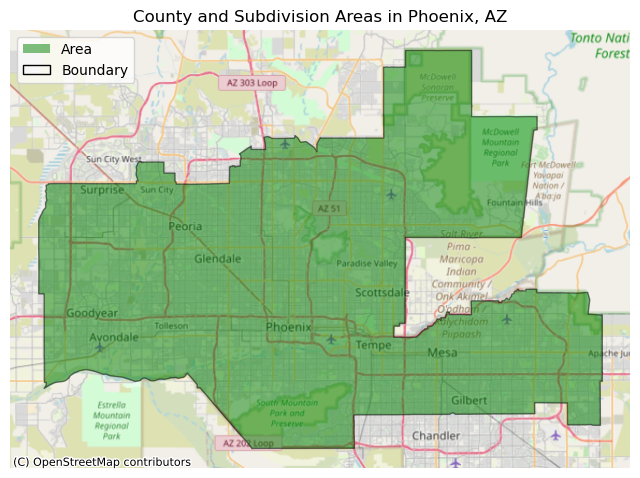

In [2]:
# Create a reproducible file path
fp = os.path.join("data", "tl_2020_04_cousub", "tl_2020_04_cousub.shp")

# Import and read Arizona shapefile
arizona = gpd.read_file(fp)

# Filter Phoenix polygon
phoenix = arizona[arizona["NAME"] == "Phoenix"]

# Plot Phoenix polygon
fig, ax = plt.subplots(figsize = (8, 8))

phoenix.plot(ax = ax, 
             color = "green", 
             edgecolor = "black",
             alpha = 0.5)

# Add a basemap
cx.add_basemap(ax,
               crs = phoenix.crs,
               source = cx.providers.OpenStreetMap.Mapnik)

# Add a legend
legend_patch = [Patch(facecolor = "green",
                      edgecolor = "none",
                      alpha = 0.5,
                      label = "Area"),
                Patch(facecolor = "none",
                      edgecolor = "black",
                      label = "Boundary")]

ax.legend(handles = legend_patch, 
          loc = "upper left")

# Add a title
ax.set_title("County and Subdivision Areas in Phoenix, AZ")

# Remove axes
ax.axis("off")

plt.show()

The purpose of filtering and plotting the Phoenix polygon is to verify its geometric shape and extent. We intend to use this polygon to clip our BII rasters, ensuring they align precisely with its shape. This will enhance our ability to visualize changes in BII in Phoenix and enable us to conduct accurate land cover statistics.   

### Visualize BII Changes in Phoenix, AZ

In [3]:
# Access MPC catalog
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace)

# Bounding box of Phoenix, AZ
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Catalog search
search = catalog.search(collections = ["io-biodiversity"],
                        bbox = bbox_of_interest,
                        datetime = time_range)

# Retrieve search items
items = search.item_collection()

# Verify
items

The output includes four items, each corresponding to a specific year from 2017 to 2020.

### Data Exploration

In [4]:
# Assign 2017 and 2020 items
item_17 = items[3]
item_20 = items[0]

We want to visualize the changes that occurred between 2017 and 2020, so we will only use the relevant items from those years.

In [5]:
# Print their asset key and title
for key in items[0].assets.keys():
    print(key, "--", items[0].assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [6]:
# Plot the 2017 rendered preview
Image(url = item_17.assets["rendered_preview"].href, width = 500)

In [7]:
# Plot the 2020 rendered preview
Image(url = item_20.assets["rendered_preview"].href, width = 500)

In [8]:
# Access the rasters from the data asset
raster_17 = rioxr.open_rasterio(item_17.assets["data"].href)
raster_20 = rioxr.open_rasterio(item_20.assets["data"].href)

# Explore rasters
print(raster_17)
print(raster_20)

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


The raster datasets have three dimensions: band, x, and y. The band dimension has a length of one, while both the x and y dimensions have a length of 7992. Before plotting, it's important to simplify our rasters by removing the unnecessary band dimension.

### Data Processing

In [9]:
# Remove the length 1 dimension (band)
raster_17 = raster_17.squeeze().drop_vars("band")
raster_20 = raster_20.squeeze().drop_vars("band")

# Verify dimensions
print("Sizes of raster_17 dimensions:", dict(raster_17.sizes))
print("Sizes of raster_20 dimensions:", dict(raster_20.sizes))

Sizes of raster_17 dimensions: {'y': 7992, 'x': 7992}
Sizes of raster_20 dimensions: {'y': 7992, 'x': 7992}


In [10]:
# Check for matching coordinate reference systems
print(f"item_17 CRS: EPSG:{item_17.properties['proj:epsg']}")
print(f"item_20 CRS: EPSG:{item_20.properties['proj:epsg']}")
print(f"phoenix CRS: {phoenix.crs}")

item_17 CRS: EPSG:4326
item_20 CRS: EPSG:4326
phoenix CRS: EPSG:4269


In [11]:
# Reproject Phoenix shapefile crs
phoenix = phoenix.to_crs(epsg = 4326)

# Verify change
print(f"phoenix CRS: {phoenix.crs}")

phoenix CRS: EPSG:4326


Now that the rasters have been simplified and their coordinate reference systems match that of the Phoenix polygon, we can clip the rasters to fit within the total bounds and precise geometry of Phoenix.

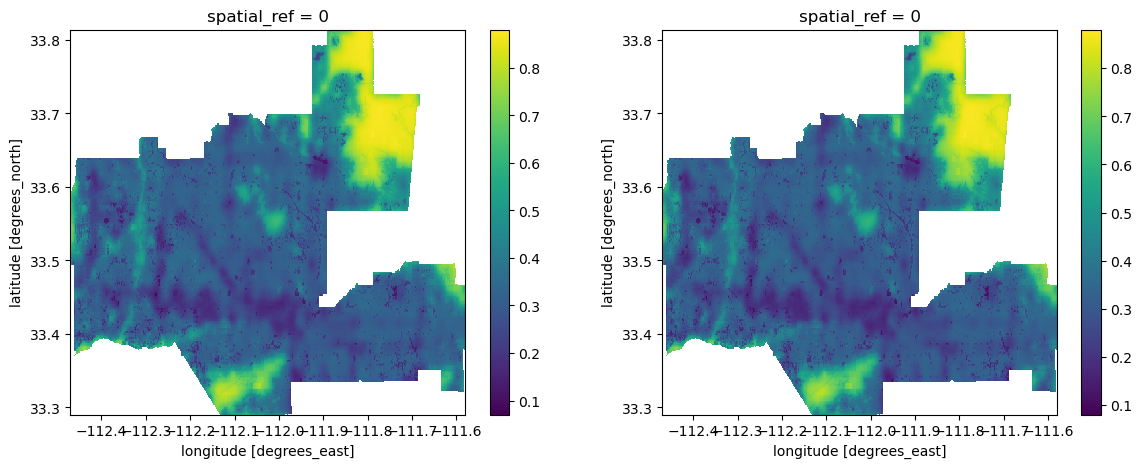

In [12]:
# Clip rasters to the Phoenix total bounds and exact geometry
clip_17 = (raster_17.rio.clip_box(*phoenix.total_bounds)
           .rio.clip(phoenix.geometry))

clip_20 = (raster_20.rio.clip_box(*phoenix.total_bounds)
           .rio.clip(phoenix.geometry))

# Plot clipped rasters
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

clip_17.plot(ax = ax[0])
clip_20.plot(ax = ax[1])

plt.show()

### Data Analysis

We aim to quantify and compare the areas with a high Biodiversity Intactness Index (BII) of 0.75 or greater between 2017 and 2020. Our goal is to calculate the percentage of area in Phoenix that meets this criterion and to plot the differences between the two years. This comparison will help us understand how urban expansion has affected areas with high biodiversity in Phoenix.

In [13]:
# Create a function to calculate the percentage of area with BII >= 0.75
def calculate_percentage_bii(raster):
    bii_area = (raster >= 0.75).sum()
    total_area = raster.count()
    percentage = (bii_area / total_area) * 100
    return percentage

# Calculate percentage for both years
percentage_17 = calculate_percentage_bii(clip_17)
percentage_20 = calculate_percentage_bii(clip_20)

# Print percentages
print(f"Percentage of Phoenix area with BII >= 0.75 in 2017: {percentage_17:.2f}%")
print(f"Percentage of Phoenix area with BII >= 0.75 in 2020: {percentage_20:.2f}%")

Percentage of Phoenix area with BII >= 0.75 in 2017: 7.13%
Percentage of Phoenix area with BII >= 0.75 in 2020: 6.49%


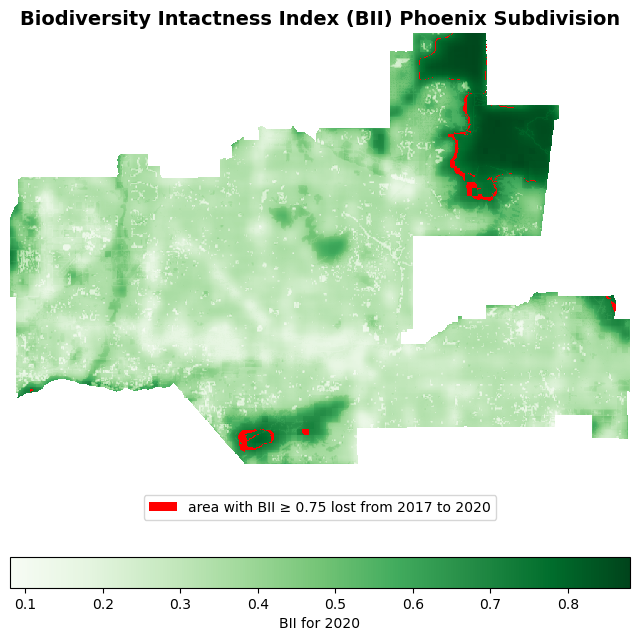

In [14]:
# Plot the area with BII >= 0.75 in 2017 that was lost by 2020
fig, ax = plt.subplots(figsize = (8, 8))

clip_20.plot(ax = ax, 
             cmap = "Greens",
             cbar_kwargs = {"orientation": "horizontal", 
                            "label": "BII for 2020"})

# Create a Boolean mask indicating areas
bii_diff = (clip_17 >= 0.75) & (clip_20 < 0.75)

bii_diff.plot(ax= ax, 
              cmap = ListedColormap(["none", "red"]), 
              add_colorbar = False)

# Add a legend for BII difference
legend_patch = [Patch(facecolor = "red",
                      label = "area with BII ≥ 0.75 lost from 2017 to 2020")]

ax.legend(handles = legend_patch,
          loc = "center",
          bbox_to_anchor = (0.5, -0.1))

# Add a title
ax.set_title("Biodiversity Intactness Index (BII) Phoenix Subdivision", 
             fontweight="bold", 
             fontsize=14)

# Remove axes
ax.axis("off")

plt.show()

**Description**

The results show a decline in areas with a Biodiversity Intactness Index (BII) of 0.75 or higher from 2017 to 2020. The accompanying plot highlights the biodiversity areas lost due to urban expansion in Phoenix, AZ, marked in red. It is evident from the plot that the most impacted regions are those with higher BII values, represented by the darker green color.